# Instructions
You will submit an HTML document to Canvas as your final version.  

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final knitted file.  

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.  

There may be a small penalty for submissions that are difficult to read or navigate.

# Part One: Data Exploration

The dataset we will study for this assignment contains information about health insurance costs for individuals with no dependents (children) in the United States. The information contained in the data is:  

- Age of primary beneficiary  
- Gender of primary beneficiary (only female, male recorded)  
- Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9  
- Whether the beneficiary smokes  
- The beneficiary’s residential area in the US, northeast, southeast, southwest, northwest  
- Individual medical costs billed by health insurance  

You can find this data at: https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1  

1. Read in the dataset, and display some summaries of the data.  

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from plotnine import *
from sklearn.compose import ColumnTransformer
import random
from sklearn.model_selection import GridSearchCV

# Set seed for reproducibility
np.random.seed(1)
random.seed(1)

In [2]:
insurance_df = pd.read_csv("https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1")
insurance_df.head()

,age,sex,bmi,smoker,region,charges
0,19,female,27.900,yes,southwest,16884.92400
1,33,male,22.705,no,northwest,21984.47061
2,32,male,28.880,no,northwest,3866.85520
3,31,female,25.740,no,southeast,3756.62160
4,60,female,25.840,no,northwest,28923.13692


In [3]:
# Descriptive Statistics
print(insurance_df[['age', 'bmi', 'charges']].describe())

              age         bmi       charges
count  431.000000  431.000000    431.000000
mean    37.960557   30.768898  12297.098118
std     16.363909    6.111362  11876.527128
min     18.000000   15.960000   1131.506600
25%     22.000000   26.357500   2710.444575
50%     34.000000   30.590000   9866.304850
75%     55.000000   35.272500  14510.872600
max     64.000000   49.060000  55135.402090


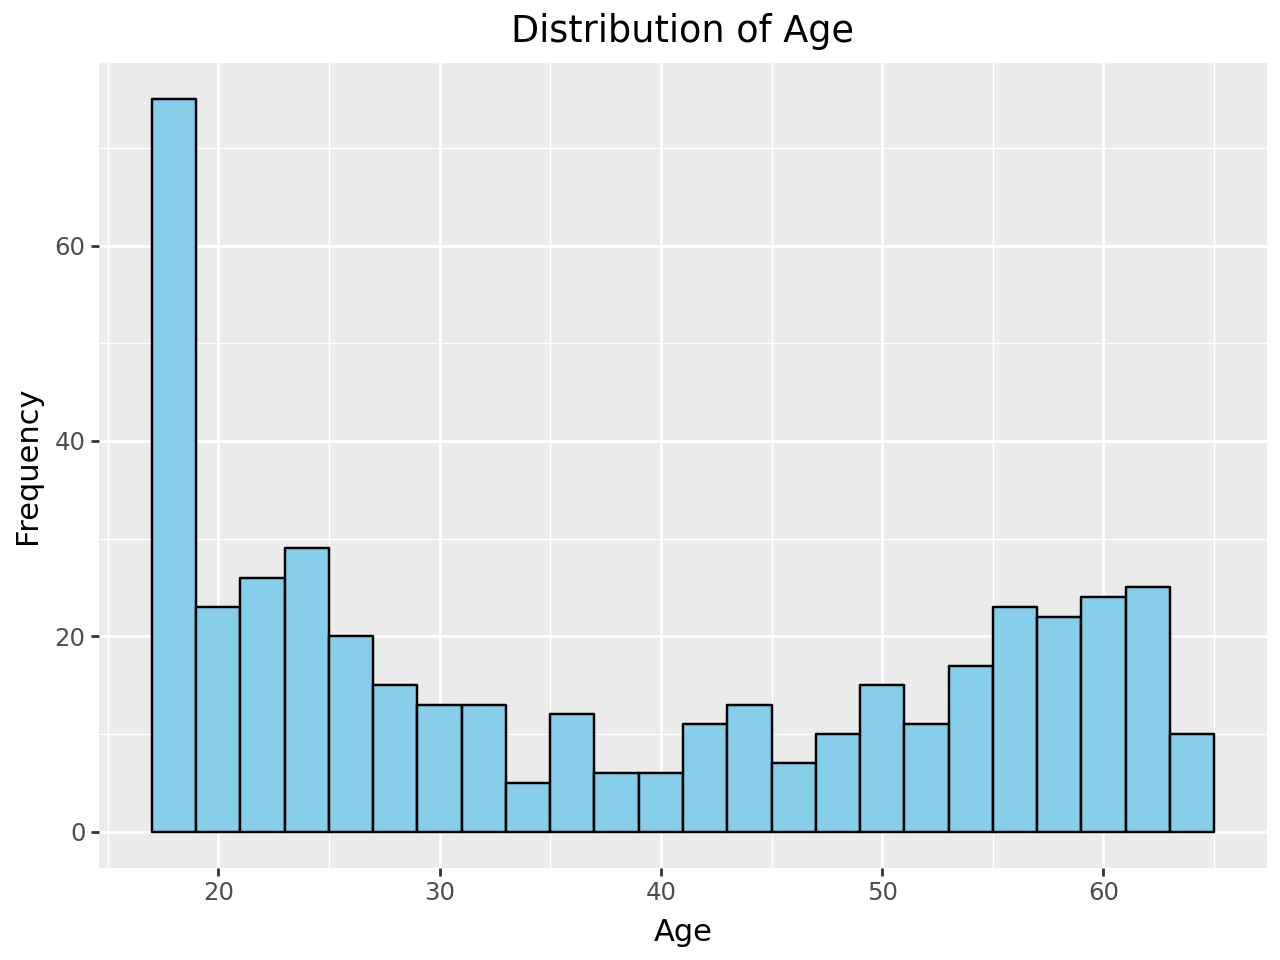

In [4]:
# Create a histogram of the 'age' column
(ggplot(insurance_df, aes(x='age')) +
 geom_histogram(binwidth=2, fill='skyblue', color='black') +
 labs(title="Distribution of Age", x="Age", y="Frequency"))

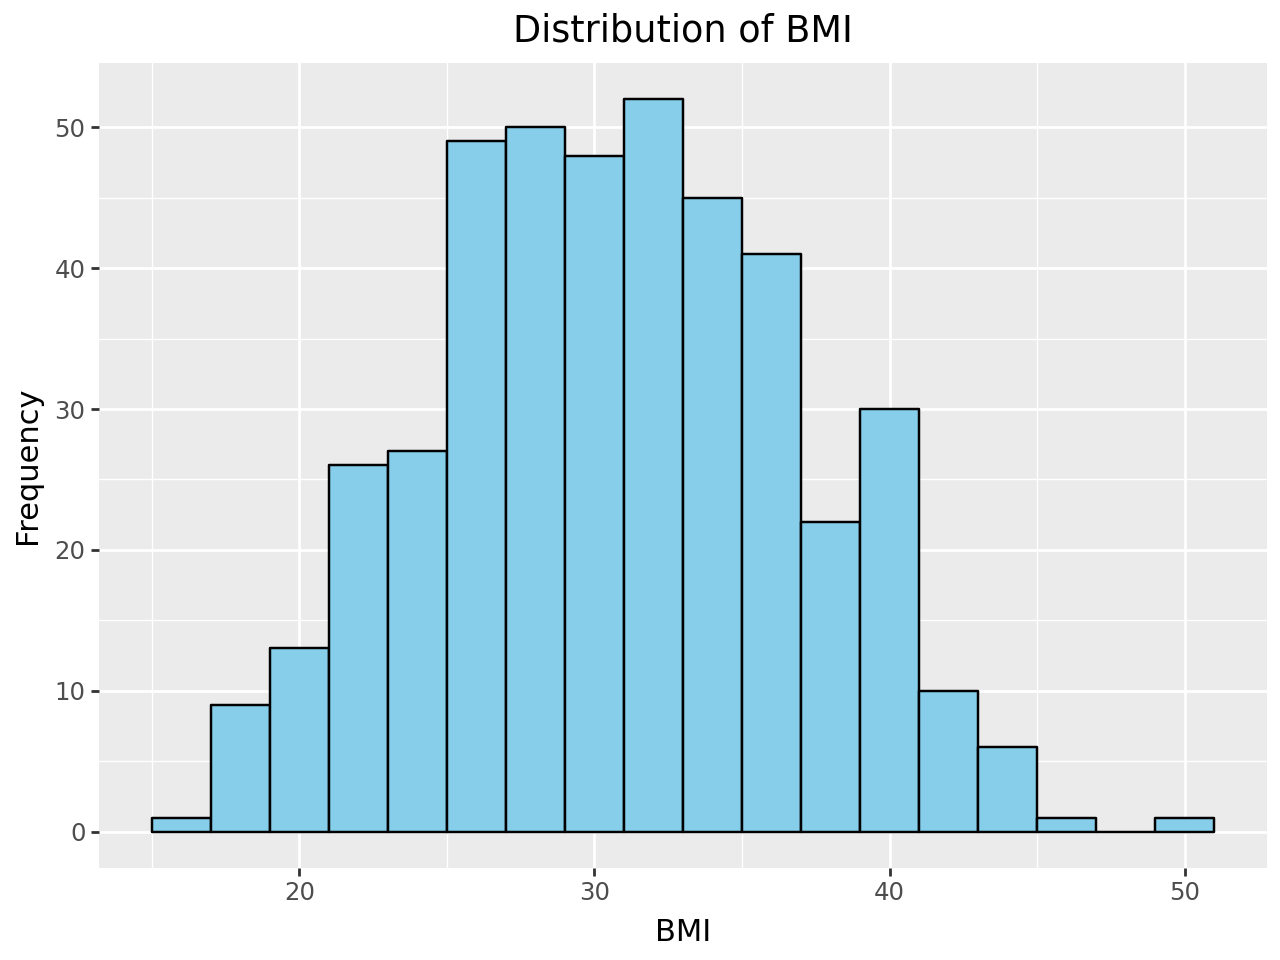

In [21]:
# Create a histogram of the 'bmi' column
(ggplot(insurance_df, aes(x='bmi')) +
 geom_histogram(binwidth=2, fill='skyblue', color='black') +
 labs(title="Distribution of BMI", x="BMI", y="Frequency"))

In [6]:
# Categorical Variable Analysis
print(insurance_df['sex'].value_counts())
print(insurance_df['smoker'].value_counts())
print(insurance_df['region'].value_counts())

sex
female    225
male      206
Name: count, dtype: int64
smoker
no     344
yes     87
Name: count, dtype: int64
region
southeast    125
northeast    108
southwest    103
northwest     95
Name: count, dtype: int64



2. Fix any concerns you have about the data.  

In [7]:
# Remove missing values
insurance_df.dropna(inplace=True)

The age data shows a clear skew, with many values clustered around age 20, while BMI  appears relatively normal. Although BMI might not need adjustment on its own, standardizing both age and BMI would be useful if we include them in a model together. This would ensure both variables are on the same scale, helping the model avoid giving one variable more weight just because it has a different range. Right now, there are no other issues with the data; any necessary standardization or encoding of variables will be handled in later steps.

3. Make up to three plots comparing the response variable (charges) to one of the predictor variables. Briefly discuss each plot.

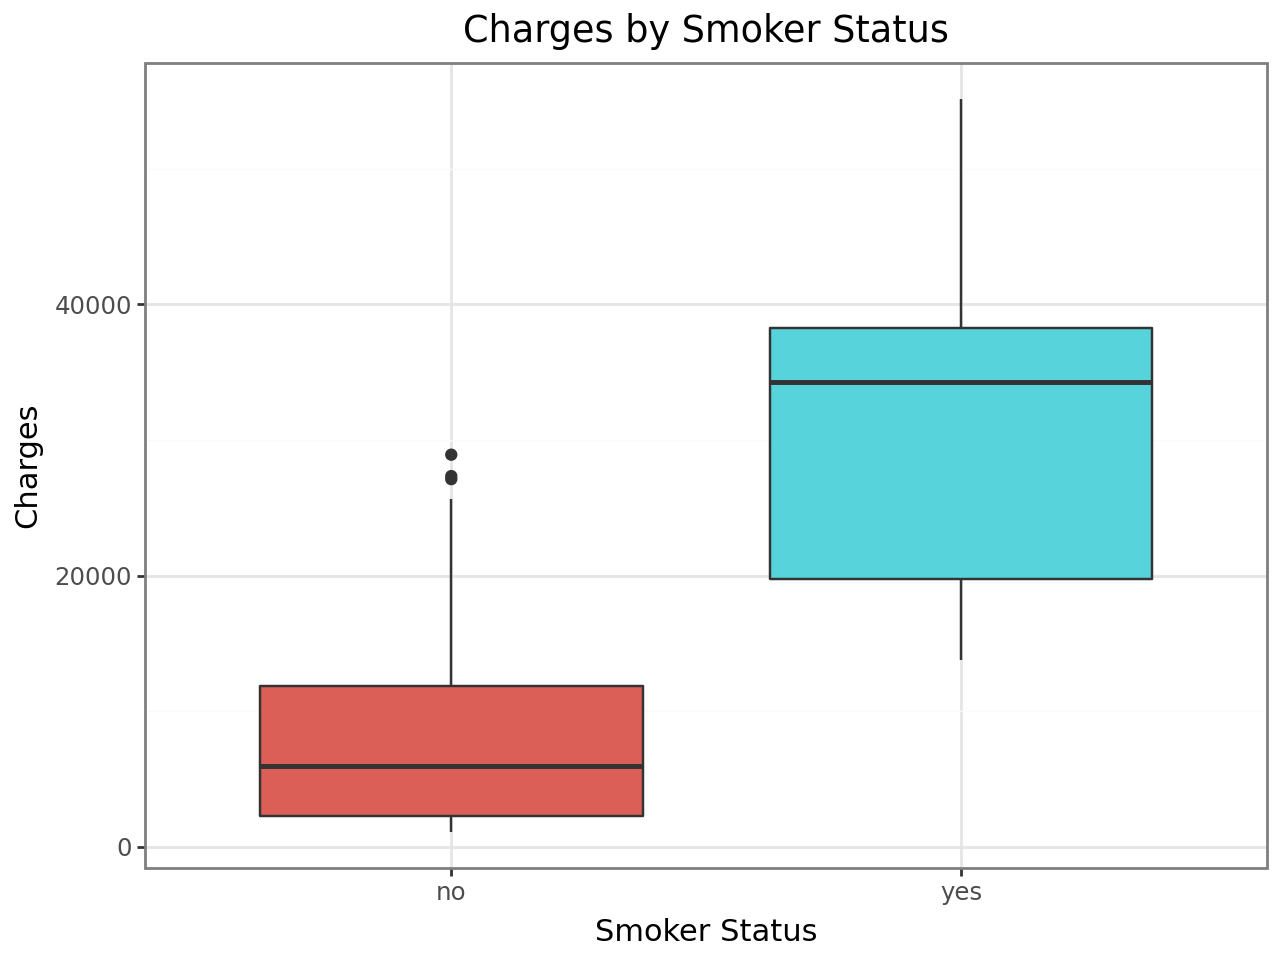

In [8]:
(ggplot(insurance_df, aes(x='smoker', y='charges', fill = 'smoker')) +
    geom_boxplot() +
    labs(title='Charges by Smoker Status',
        x='Smoker Status',
        y='Charges'
    ) +
    theme_bw() +
    theme(legend_position='none') 
)

This box plot reveals a clear difference in medical costs between smokers and non-smokers. Smokers tend to have significantly higher medical charges than non-smokers. The median charge for smokers is significantly higher, which suggests that smoking is associated with increased healthcare expenses. Additionally, the range of charges is much wider for smokers, which may be due to health complications related to smoking. Meanwhile, non-smokers have more stable medical costs, with a narrower range of charges with fewer outliers. This plot suggests a strong link between smoking and higher healthcare costs.

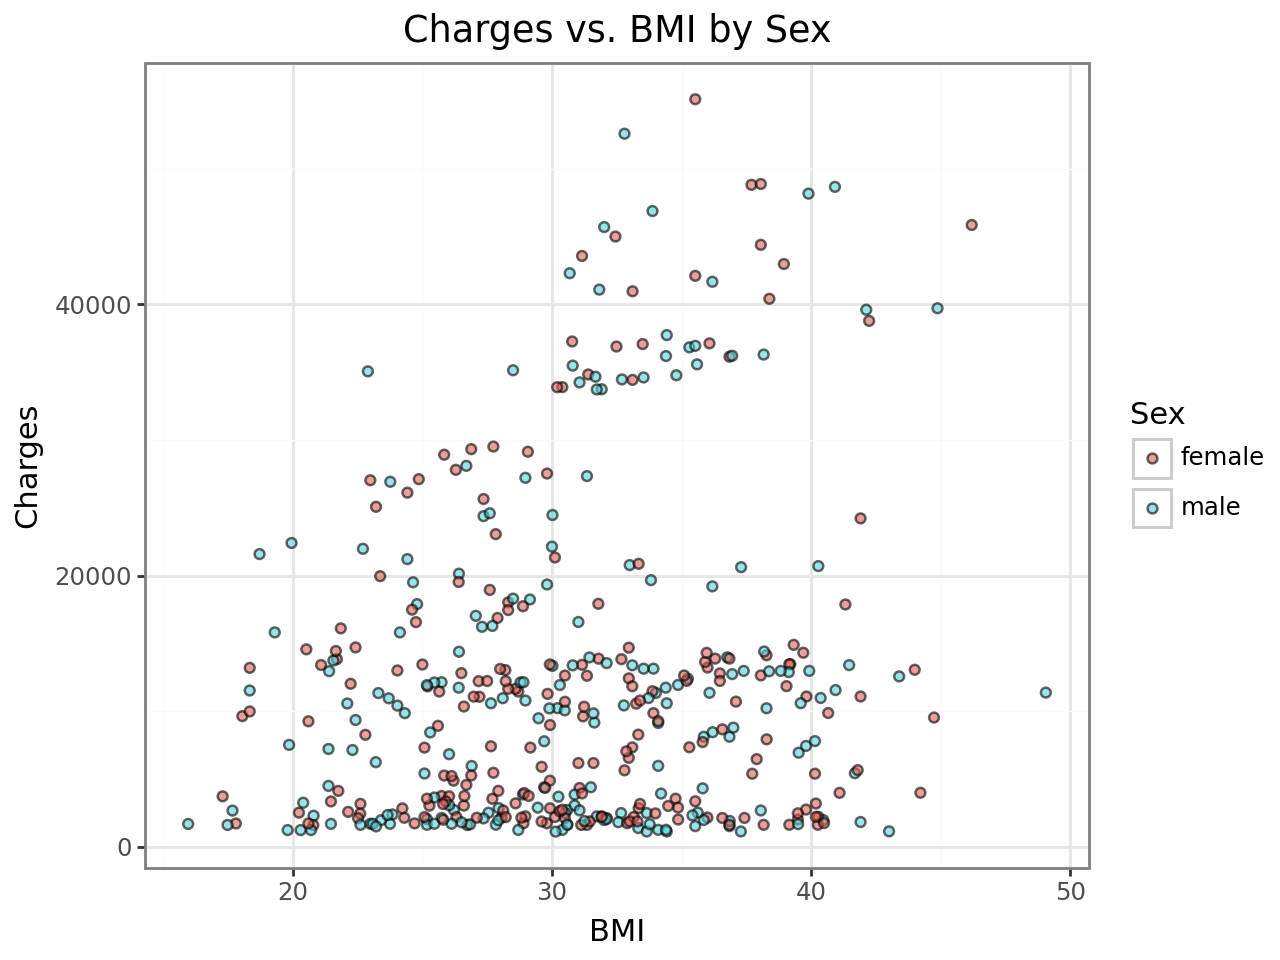

In [9]:
(ggplot(insurance_df, aes(x='bmi', y='charges', fill = 'sex')) +
    geom_point(alpha=0.6) +
    labs(
        title='Charges vs. BMI by Sex',
        x='BMI',
        y='Charges',
        fill = 'Sex'
    ) +
    theme_bw()
)

This scatter plot illustrates that higher BMI values are generally associated with a broader range of medical charges, especially at the higher end. This could indicate that individuals with higher BMIs may face greater medical expenses. While there is variability in charges within each gender, there isn’t a distinct difference between male and female charges based solely on BMI, as both groups follow similar patterns. This plot suggests that BMI might play a role in influencing medical costs, especially at higher values.

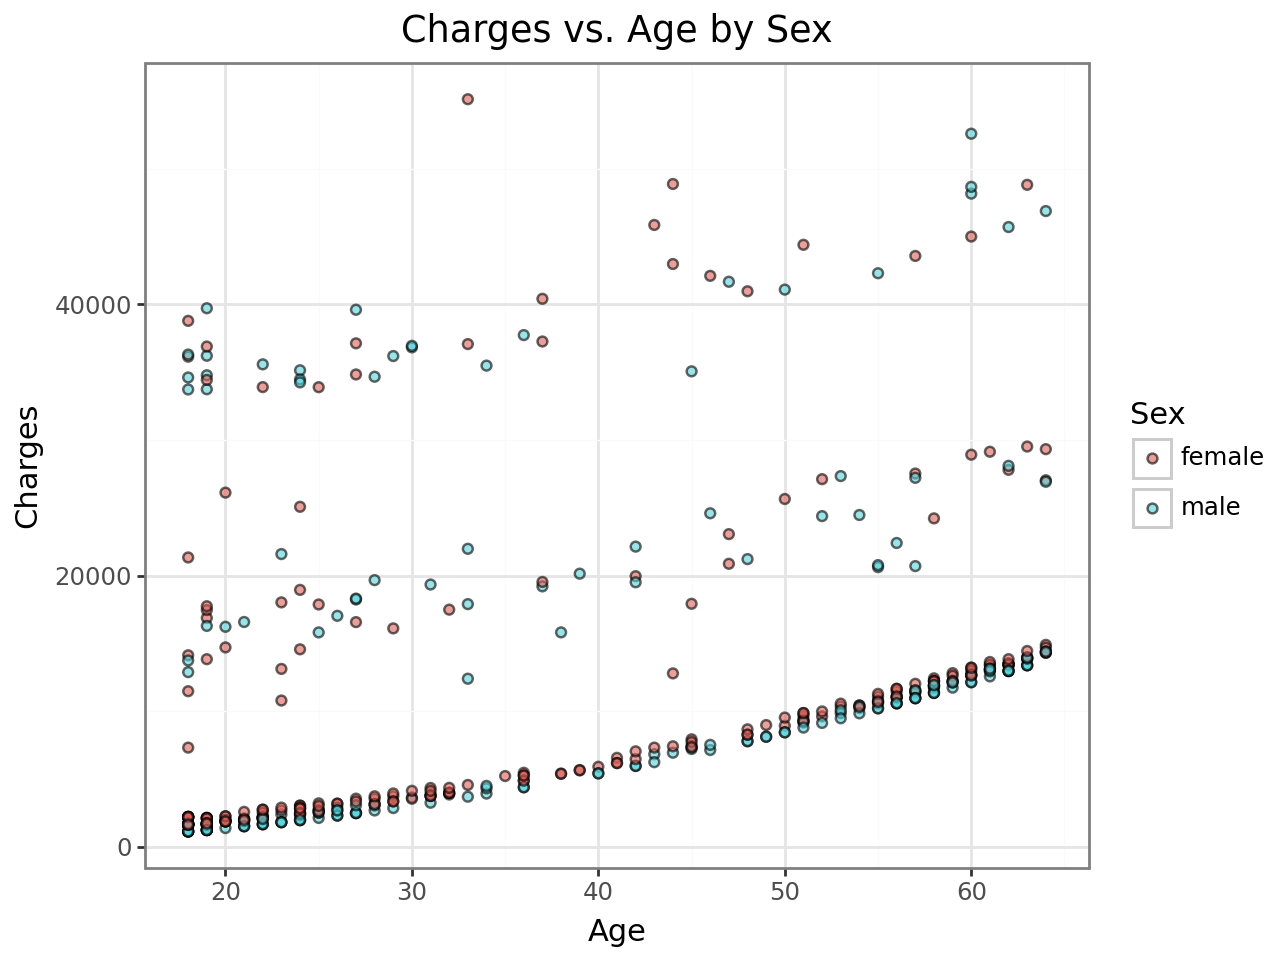

In [10]:
(ggplot(insurance_df, aes(x='age', y='charges', fill = 'sex')) +
    geom_point(alpha=0.6) +
    labs(
        title='Charges vs. Age by Sex',
        x='Age',
        y='Charges',
        fill = 'Sex'
    ) +
    theme_bw()
)

This scatter plot shows that as individuals get older, medical charges tend to increase. This pattern is especially clear after age 40, where we see more variation in costs, and some individuals have much higher charges. Both males and females follow similar patterns, with no strong difference in charges based on gender at each age. Overall, this plot suggests that age is an important factor in medical costs, with older adults generally having higher expenses.

# Part Two: Simple Linear Models
1. Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.

In [12]:
# Define Target and Predictors
y = insurance_df["charges"] # Response
X = insurance_df.drop("charges", axis = 1) # Predictors

# Test/training split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Standardize 'age'
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

# Create pipeline object for linear regression
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept = lr_fit.named_steps['linear_regression'].intercept_
coeff = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2)
print("MSE:", mse)
print("Intercept:", intercept)
print("Coefficient for Age:", coeff)

R_Squared: 0.15290593504930683
MSE: 98969665.21680352
Intercept: 12493.160398975233
Coefficient for Age: [3520.72536746]


$$\hat{\text{Charges}} = 12493.16 + 3520.73 (\text{Age})$$

The model explains only about $15.29\%$ of the variance in the insurance charges. This is a low $R^2$ value, which indicates that age alone is not a strong predictor of medical charges. There are likely other factors, such as smoking status, BMI, or region, that contribute more significantly to the variation in charges.  

The Mean Squared Error (MSE) is around $98969665.22$. This high MSE value indicates that the model's predictions have a significant amount of error, likely because age alone does not strongly predict charges.  

The intercept is $12493.16$. When an individual is 0 (a newborn baby), the predicted insurance cost is $12493.16. An age of zero isn't meaningful in this context, but the intercept serves as a baseline in the regression equation.  

The coefficient for Age is $3520.73$. For each one standard deviation increase in age, insurance charges are expected to increase by approximately $3520.73, holding all else constant. This positive coefficient suggests that older individuals tend to have higher medical costs.  


2. Make a model that also incorporates the variable sex. Report your results.

In [13]:
# Model with 'age' and 'sex'

# Standardize 'age' and dummify 'sex'
ct2 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"]),
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["sex"]) # Reference group: female
  ],
  remainder = "drop"
)

# New pipeline object with new column transformer
lr_pipeline = Pipeline(
  [("preprocessing", ct2),
  ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept2 = lr_fit.named_steps['linear_regression'].intercept_
coeff2 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2_2 = r2_score(y_test, y_test_pred)
mse2 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_2)
print("MSE:", mse2)
print("Intercept:", intercept2)
print("Coefficients", coeff2)

R_Squared: 0.15411735770595847
MSE: 98828129.46566842
Intercept: 12431.114115021355
Coefficients [3521.43507626  129.29644979]


$$\hat{\text{Charges}} = 12431.11 + 3521.44 (\text{Age}) + + 129.30 (\text{Sex})$$

The model explains only about $15.41\%$ of the variance in the insurance charges. This is a low $R^2$ value, which indicates that age and sex together are not strong predictors of medical charges. There are likely other factors, such as smoking status, BMI, or region, that contribute more significantly to the variation in charges.  

The Mean Squared Error (MSE) is around $98828129.47$. This high MSE value indicates that the model's predictions have a significant amount of error, likely because age and sex alone do not strongly predict charges.

The intercept is $12431.11$. This represents the predicted insurance charges for a baseline individual (a female with age at the mean, since age is standardized). While this value serves as a baseline, it does not have a meaningful real-world interpretation on its own due to the standardization.

The coefficient for Age is $3521.44$. For each one standard deviation increase in age, insurance charges are expected to increase by approximately $3521.44, holding all else constant. This positive coefficient suggests that older individuals tend to have higher medical costs.

The coefficient for Sex is $129.30$. This indicates that males are expected to have insurance charges that are approximately $129.30 higher than females, assuming age is held constant.

3. Now make a model that does not include sex, but does include smoker. Report your results.

In [14]:
# Model with 'age' and 'smoker'

# Standardize 'age' and dummify 'smoker'
ct3 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"]),
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["smoker"]) # Reference group: no (non-smoker)
  ],
  remainder = "drop"
)

# New pipeline object with new column transformer
lr_pipeline = Pipeline(
  [("preprocessing", ct3),
  ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept3 = lr_fit.named_steps['linear_regression'].intercept_
coeff3 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2_3 = r2_score(y_test, y_test_pred)
mse3 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_3)
print("MSE:", mse3)
print("Intercept:", intercept3)
print("Coefficients", coeff3)

R_Squared: 0.735165309400182
MSE: 30941782.91520125
Intercept: 7340.482104125219
Coefficients [ 3904.97573435 24840.52371995]


$$\hat{\text{Charges}} = 7340.48 + 3904.98 (\text{Age}) + 24840.52 (\text{Smoker})$$

The model explains about $73.52\%$ of the variance in the insurance charges. This is a relatively high $R^2$ value, indicating that age and smoking status together are strong predictors of medical charges. Including smoker status in the model appears to significantly improve its ability to explain the variation in charges.

The Mean Squared Error (MSE) is around $30941782.92$. This lower MSE value, compared to previous models, indicates that the model’s predictions have less error, suggesting that smoker status is a key factor in predicting charges.

The intercept is $7340.48$. This represents the predicted insurance cost for a non-smoker at the mean age (since age is standardized). Although this value serves as a baseline, it does not have a direct real-world interpretation due to the standardization of age.

The coefficient for Age is $3904.98$. For each one standard deviation increase in age, insurance charges are expected to increase by approximately $3904.98, holding smoking status constant. This positive coefficient suggests that older individuals tend to have higher medical costs.

The coefficient for Smoker is $24840.52$. This indicates that smokers are expected to have insurance charges that are approximately $24840.52 higher than non-smokers, assuming age is held constant. This large positive value highlights that being a smoker is strongly associated with higher medical costs.

4. Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.


Model Q3 provides a better fit for the data than Model Q2 because of its higher R-squared and lower MSE. Model Q3’s R-squared value of 0.7352 indicates it explains 73.52% of the variance in insurance charges, compared to only 15.41% for Model Q2. Additionally, Model Q3 has a significantly lower MSE (30941782.92) than Model Q2 (98828129.47), meaning its predictions are closer to actual charges. Including smoking status in Model Q3 is likely the reason for the improvement, as it captures an important factor influencing insurance costs. Overall, the higher accuracy and explanatory power of Model Q3 suggest it is the better model for predicting insurance charges.

# Part Three: Multiple Linear Models 

Now let’s consider including multiple quantitative predictors.  

1. Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

In [15]:
# Model with 'age' and 'bmi'

# Standardize 'age' and 'bmi'
ct4 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"]),
  ],
  remainder = "drop"
)

# New pipeline object with new column transformer
lr_pipeline = Pipeline(
  [("preprocessing", ct4),
  ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept4 = lr_fit.named_steps['linear_regression'].intercept_
coeff4 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2_4 = r2_score(y_test, y_test_pred)
mse4 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_4)
print("MSE:", mse4)
print("Intercept:", intercept4)
print("Coefficients", coeff4)

R_Squared: 0.1797485291449319
MSE: 95833528.79333656
Intercept: 12493.160398975233
Coefficients [3252.93204065 1721.90174511]


$$\hat{\text{Charges}} = 12493.16 + 3252.93 (\text{Age}) + 1721.9 (\text{BMI})$$

The model explains only about $17.97\%$ of the variance in the insurance charges. This is a low $R^2$ value, which indicates that age and BMI together are not strong predictors of medical charges. There are likely other factors, such as smoking status or region, that contribute more significantly to the variation in charges.

The Mean Squared Error (MSE) is around $95833528.79$. This high MSE value indicates that the model's predictions have a significant amount of error, suggesting that age and BMI alone do not strongly predict charges.

The intercept is $12493.16$. This represents the predicted insurance cost for an individual with average values for age and BMI (since both variables are standardized). While this serves as a baseline, it doesn’t have a direct interpretation in this context.

The coefficient for Age is $3252.93$. For each one standard deviation increase in age, insurance charges are expected to increase by approximately $3252.93, holding BMI constant. This positive coefficient suggests that older individuals tend to have higher medical costs.

The coefficient for BMI is $1721.90$. For each one standard deviation increase in BMI, insurance charges are expected to increase by approximately $1721.90, holding age constant. This positive coefficient implies that individuals with higher BMI may incur higher medical costs.

The MSE for this model, which includes both age and BMI, is around $95833528.79$, while the MSE for the model in Part Two Q1, which only included age as a predictor, was approximately $98969665.22$. This decrease in MSE suggests that adding BMI as a predictor slightly improves the model's predictive accuracy.

The R-squared value for this model is $17.97\%$, compared to $15.29\%$ in the model with only age. This indicates that including BMI helps the model explain a bit more of the variance in insurance charges, but it’s still a relatively low R-squared value. So while adding BMI improves the model slightly, both age and BMI together still explain only a small portion of the variation in charges.

2. Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?

In [16]:
# Standardize 'age' and generate polynomial features (age and age^2)
ct5 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

# New pipeline object with new column transformer
lr_pipeline = Pipeline(
  [("preprocessing", ct5),
   ("polynomial", PolynomialFeatures(degree=2, include_bias=False)),
   ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept5 = lr_fit.named_steps['linear_regression'].intercept_
coeff5 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2_5 = r2_score(y_test, y_test_pred)
mse5 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_5)
print("MSE:", mse5)
print("Intercept:", intercept5)
print("Coefficients", coeff5)

R_Squared: 0.15287835069471756
MSE: 98972888.01631525
Intercept: 12799.868527427156
Coefficients [3596.05080966 -306.70812845]


This model, with both age and age^2 as predictors, has an R-squared of approximately 0.1529 and an MSE of around 98972888.02. These values are nearly identical to those in the model with age alone from P2 Q1, which also had an R-squared of about 0.1529 and an MSE of approximately 98969665.22. This minimal difference indicates that adding age^2 does not improve the model's ability to explain variance in charges or reduce prediction error.

3. Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?

In [17]:
# Standardize 'age' and generate polynomial features
ct6 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

# New pipeline object with new column transformer
lr_pipeline_deg4 = Pipeline(
  [("preprocessing", ct5),
   ("polynomial", PolynomialFeatures(degree=4, include_bias=False)),
   ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit_deg4 = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept6 = lr_fit_deg4.named_steps['linear_regression'].intercept_
coeff6 = lr_fit_deg4.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit_deg4.predict(X_train)
y_test_pred = lr_fit_deg4.predict(X_test)

# Calculate R-Squared and MSE
r2_6 = r2_score(y_test, y_test_pred)
mse6 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_6)
print("MSE:", mse6)
print("Intercept:", intercept6)
print("Coefficients", coeff6)

R_Squared: 0.15287835069471756
MSE: 98972888.01631525
Intercept: 12799.868527427156
Coefficients [3596.05080966 -306.70812845]


Compared to the model in P2 Q1, the degree 4 polynomial model shows a small improvement. The R-squared for this model is about 0.1555, slightly higher than the 0.1529 in the model that only included age. This means the polynomial terms for age add a bit more explanatory power, but they still explain only a small portion of the variation in insurance charges.

The MSE for the polynomial model is around 98661541.37, which is slightly lower than the 98969665.22 from the simpler model. This small drop in MSE suggests a minor improvement in prediction accuracy. Including higher-degree terms for age doesn’t seem to make a big difference in how well the model fits or predicts.

4. Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

In [18]:
# Standardize 'age' and generate polynomial features
ct7 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

# New pipeline object with new column transformer
lr_pipeline_deg12 = Pipeline(
  [("preprocessing", ct5),
   ("polynomial", PolynomialFeatures(degree=12, include_bias=False)),
   ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit_deg12 = lr_pipeline_deg12.fit(X_train, y_train)

# Get coefficients
intercept7 = lr_fit_deg12.named_steps['linear_regression'].intercept_
coeff7 = lr_fit_deg12.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit_deg12.predict(X_train)
y_test_pred = lr_fit_deg12.predict(X_test)

# Calculate R-Squared and MSE
r2_7 = r2_score(y_test, y_test_pred)
mse7 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_7)
print("MSE:", mse7)
print("Intercept:", intercept7)
print("Coefficients", coeff7)

R_Squared: 0.06492670742032913
MSE: 109248659.09097224
Intercept: 10636.761879411279
Coefficients [  -3160.23322909   36849.19392469   96953.74605012  -79553.92143713
 -301740.75481424   68420.54943537  382743.71666157  -64238.07265943
 -218267.2262725    52091.73869056   46320.1137164   -15389.32014429]


The polynomial model of degree 12 performs worse than the model in P2 Q1. The R-squared for this model is approximately 0.0649, significantly lower than the 0.1529 in the simpler model. This drop in R-squared suggests that the degree 12 polynomial model actually explains less of the variance in insurance charges, likely due to overfitting.

The MSE for the degree 12 model is 109248659.09, which is also higher than the MSE of 98969665.22 in the simpler model. This increase in MSE indicates that the predictions from the degree 12 model are less accurate. Overall, adding many polynomial terms has led to a poorer fit, likely because the model is too complex and fails to generalize well to the test data.

5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

Based on the MSE and R-squared, the model with age and smoker status from P2 Q3 appears to be the best model. This model had a higher R-squared (around 0.735) and a lower MSE (about 30941782.92), indicating it explains a larger proportion of the variance in insurance charges and has better prediction accuracy compared to other models.

However, I don't think this is the "best" model just because it performs well on these metrics. There are still other factors that may be important to consider, such as BMI or region, that are not included in this model. These factors could also affect medical costs. So while the model with age and smoker status performed the best in terms of MSE and R-squared, I think it is important to consider other potential predictors that may be important.

6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

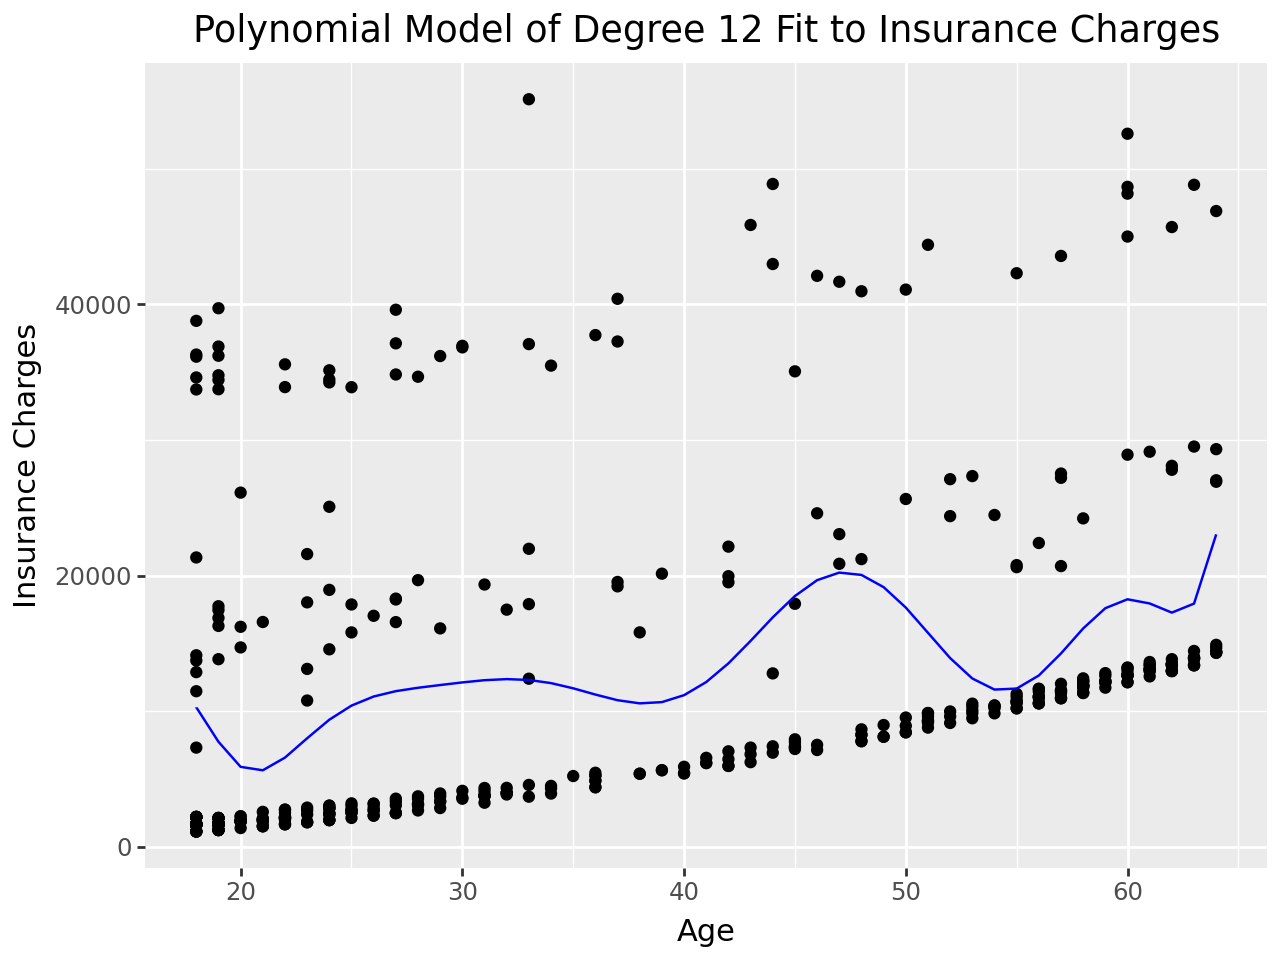

In [19]:
age_data = insurance_df[['age']] # Extract 'age'
insurance_df['degree_12'] = lr_fit_deg12.predict(age_data) # Predict charges using polynomial model of degree 12

(ggplot(insurance_df, aes(x='age')) +
    geom_point(aes(y = 'charges')) +
    geom_line(aes(y = 'degree_12'), color = 'blue') +
    labs(title = "Polynomial Model of Degree 12 Fit to Insurance Charges",
           x = "Age",
           y = "Insurance Charges")
)

# Part Four: New data  

Great news! We’ve managed to collect data about the insurance costs for a few more individuals. You can find the new dataset here: https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1  

Consider the following possible models:  
- Only age as a predictor.  
- age and bmi as a predictor.  
- age, bmi, and smoker as predictors (no interaction terms)  
- age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)  
- age, bmi, and smokeras predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)  

For each model, fit the model on the original data.  

Then, use the fitted model to predict on the new data.  

Report the MSE for each model’s new predictions. Based on this, which is the best model to use?  

Make a plot showing the residuals of your final chosen model.  

In [3]:
insurance_new = pd.read_csv("https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1")
insurance_new.head()

,age,sex,bmi,smoker,region,charges
0,23,male,34.400,no,southwest,1826.84300
1,56,male,40.300,no,southwest,10602.38500
2,18,male,34.100,no,southeast,1137.01100
3,63,female,23.085,no,northeast,14451.83515
4,63,male,28.310,no,northwest,13770.09790


In [4]:
# Set the original data as the training data and the new data as the test data
y_train = insurance_df["charges"]
X_train = insurance_df.drop("charges", axis = 1)

y_test = insurance_new["charges"]
X_test = insurance_new.drop("charges", axis = 1)

In [5]:
# Model 1: Using only 'age' as a predictor

# Standardize 'age'
ct8 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

lr_pipeline = Pipeline(
  [("preprocessing", ct8),
  ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept8 = lr_fit.named_steps['linear_regression'].intercept_
coeff8 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2_8 = r2_score(y_test, y_test_pred)
mse8 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_8)
print("MSE:", mse8)
print("Intercept:", intercept8)
print("Coefficient for Age:", coeff8)

R_Squared: 0.12236515675533055
MSE: 136077136.50195494
Intercept: 12297.098118187932
Coefficient for Age: [3739.70080761]


In [6]:
# Model 2: Using 'age' and 'bmi' as predictors

# Standardize 'age' and 'bmi'
ct9 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"]),
  ],
  remainder = "drop"
)

# New pipeline object with new column transformer
lr_pipeline = Pipeline(
  [("preprocessing", ct9),
  ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept9 = lr_fit.named_steps['linear_regression'].intercept_
coeff9 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2_9 = r2_score(y_test, y_test_pred)
mse9 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_9)
print("MSE:", mse9)
print("Intercept:", intercept9)
print("Coefficients", coeff9)

R_Squared: 0.14455628272331222
MSE: 132636406.1108129
Intercept: 12297.098118187932
Coefficients [3535.35939421 1728.75207656]


In [7]:
# Model 3: Using 'age', 'bmi', and 'smoker' as predictors (no interaction terms)   

# Standardize 'age' and 'bmi' and dummify 'smoker'
ct10 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"]),
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["smoker"]) # Reference group: no (non-smoker)
  ],
  remainder = "drop"
)

# New pipeline object with new column transformer
lr_pipeline = Pipeline(
  [("preprocessing", ct10),
  ("linear_regression", LinearRegression())]
)

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept10 = lr_fit.named_steps['linear_regression'].intercept_
coeff10 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2_10 = r2_score(y_test, y_test_pred)
mse10 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_10)
print("MSE:", mse10)
print("Intercept:", intercept10)
print("Coefficients", coeff10)

R_Squared: 0.77183115650478
MSE: 35377541.24141633
Intercept: 7443.703547291554
Coefficients [ 3934.57463693  1717.24340827 24043.82827651]


In [8]:
# Model 4: Using 'age', and 'bmi', with both quantitative variables having an interaction term with 'smoker' (i.e. the formula ~ (age + bmi):smoker)  
# Main effects of 'age' and 'bmi' plus their interactions with 'smoker', but no main effect of 'smoker'

# Creating interactions by hand
insurance_df['age_smoker'] = insurance_df['age'] * (insurance_df['smoker']=='yes').astype(int) # Treats 'smoker' as numeric
insurance_df['bmi_smoker'] = insurance_df['bmi'] * (insurance_df['smoker']=='yes').astype(int)

insurance_new['age_smoker'] = insurance_new['age'] * (insurance_new['smoker']=='yes').astype(int)
insurance_new['bmi_smoker'] = insurance_new['bmi'] * (insurance_new['smoker']=='yes').astype(int)

# Standardize 'age_smoker' and 'bmi_smoker'
ct11 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ['age', 'bmi', 'age_smoker', "bmi_smoker"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# New pipeline object with new column transformer
lr_pipeline = Pipeline(
  [("preprocessing", ct11),
  ("linear_regression", LinearRegression())]
)

# Define test and training data with interaction variables
X_train_new = insurance_df.drop("charges", axis = 1)
y_train_new = insurance_df["charges"]

X_test_new = insurance_new.drop("charges", axis = 1)
y_test_new = insurance_new["charges"]

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train_new, y_train_new)

# Get coefficients
intercept11 = lr_fit.named_steps['linear_regression'].intercept_
coeff11 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train_new)
y_test_pred = lr_fit.predict(X_test_new)

# Calculate R-Squared and MSE
r2_11 = r2_score(y_test, y_test_pred)
mse11 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_11)
print("MSE:", mse11)
print("Intercept:", intercept11)
print("Coefficients", coeff11)


R_Squared: 0.8400778135676981
MSE: 24795908.412643366
Intercept: 12297.098118187932
Coefficients [ 4419.3821379    619.47836699 -1681.33354174 11684.44801783]


In [10]:
# Model 5: Using 'age', 'bmi', and 'smoker' as predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)  

# Standardize 'age' and 'bmi' and dummify 'smoker'
ct_dummies = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"]),
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["smoker"]) # Reference group: no (non-smoker)
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

# Apply CT to training data to get column names
X_train_dummies = ct_dummies.fit_transform(X_train)
X_train_dummies

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__age", "dummify__smoker_yes"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__bmi", "dummify__smoker_yes"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

lr_pipeline = Pipeline(
  [("preprocessing", ct_dummies),
   ("interactions", ct_inter),
   ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Get coefficients
intercept12 = lr_fit.named_steps['linear_regression'].intercept_
coeff12 = lr_fit.named_steps['linear_regression'].coef_

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate R-Squared and MSE
r2_12 = r2_score(y_test, y_test_pred)
mse12 = mean_squared_error(y_test, y_test_pred)

print("R_Squared:", r2_12)
print("MSE:", mse12)
print("Intercept:", intercept12)
print("Coefficients", coeff12)

R_Squared: 0.8594886795699617
MSE: 21786256.866852567
Intercept: 7440.91954545411
Coefficients [ 0.00000000e+00  4.21992619e+03  1.20537009e+04 -2.03548032e+02
  3.63797881e-12  3.27260287e+01  1.20537009e+04  9.04143422e+03]


In [11]:
metrics = {
    "Model": ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"],
    "R_Squared": [r2_8, r2_9, r2_10, r2_11, r2_12],
    "MSE": [mse8, mse9, mse10, mse11, mse12]
}

metrics_df = pd.DataFrame(metrics)

print(metrics_df)

     Model  R_Squared           MSE
0  Model 1   0.122365  1.360771e+08
1  Model 2   0.144556  1.326364e+08
2  Model 3   0.771831  3.537754e+07
3  Model 4   0.840078  2.479591e+07
4  Model 5   0.859489  2.178626e+07


Based on the MSE and R-squared values, Model 5 appears to be the best model. It has the highest R-squared value of 0.859, indicating it explains a significant portion of the variance in insurance charges. Additionally, it has the lowest MSE of 21786256.87, meaning its predictions are closer to the actual values compared to the other models. Model 5, which includes 'age', 'bmi', and 'smoker' as predictors, with both quantitative variables having an interaction term with smoker, captures the complexity in the data more effectively. This suggests that including smoker interactions with both age and BMI helps improve the model’s predictive accuracy.

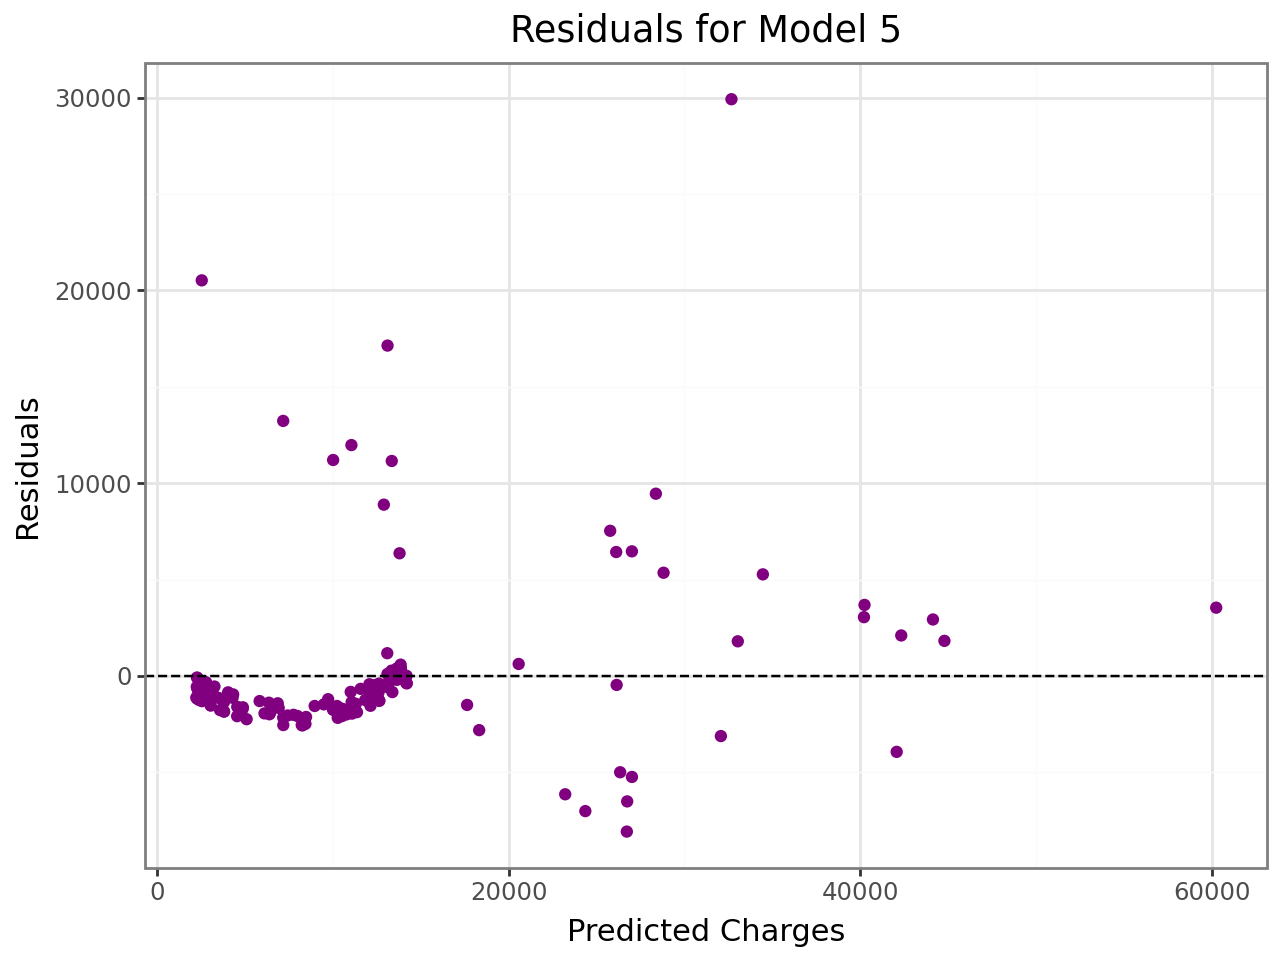

In [12]:
# Plot of residuals for best model: Model 5

# Predict on the test data and calculate residuals
y_test_pred = lr_fit.predict(X_test)
residuals = y_test - y_test_pred

# Create a DataFrame for plotting
residuals_df = pd.DataFrame({
    'Predicted': y_test_pred,
    'Residuals': residuals
})

# Plot the residuals
(ggplot(residuals_df, aes(x='Predicted', y='Residuals')) +
    geom_point(color='purple') +
    geom_hline(yintercept=0, linetype="dashed") +
    labs(title="Residuals for Model 5",
         x="Predicted Charges",
         y="Residuals") + 
    theme_bw()
)


# Part Five: Full Exploration  
Using any variables in this dataset, and any polynomial of those variables, find the model that best predicts on the new data after being fit on the original data.  

Make a plot showing the residuals of your final chosen model.  

In [15]:
# Creating interactions by hand
insurance_df['age_bmi'] = insurance_df['age'] * insurance_df['bmi']
insurance_df['age_smoker'] = insurance_df['age'] * (insurance_df['smoker']=='yes').astype(int)
insurance_df['age_sex'] = insurance_df['age'] * (insurance_df['sex']=='male').astype(int)
insurance_df['bmi_smoker'] = insurance_df['bmi'] * (insurance_df['smoker']=='yes').astype(int)
insurance_df['bmi_sex'] = insurance_df['bmi'] * (insurance_df['sex']=='male').astype(int)
insurance_df['sex_smoker'] = (insurance_df['sex']=='male').astype(int) * (insurance_df['smoker']=='yes').astype(int)

insurance_new['age_bmi'] = insurance_new['age'] * insurance_new['bmi']
insurance_new['age_smoker'] = insurance_new['age'] * (insurance_new['smoker'] == 'yes').astype(int)
insurance_new['age_sex'] = insurance_new['age'] * (insurance_new['sex'] == 'male').astype(int)
insurance_new['bmi_smoker'] = insurance_new['bmi'] * (insurance_new['smoker'] == 'yes').astype(int)
insurance_new['bmi_sex'] = insurance_new['bmi'] * (insurance_new['sex'] == 'male').astype(int)
insurance_new['sex_smoker'] = (insurance_new['sex'] == 'male').astype(int) * (insurance_new['smoker'] == 'yes').astype(int)

y_train = insurance_df["charges"]
X_train = insurance_df.drop("charges", axis = 1)

y_test = insurance_new["charges"]
X_test = insurance_new.drop("charges", axis = 1)

degrees = np.arange(1, 4)  # Polynomial degrees to try

results = []

# Set up combinations for predictors, polynomial degrees, and interactions
predictor_combinations = [
    ['age', 'bmi'],
    ['age', 'bmi', 'sex'],
    ['age', 'bmi', 'smoker'],
    ['age', 'bmi', 'region'],
    ['age', 'bmi', 'smoker', 'sex'],
    ['age', 'bmi', 'smoker', 'region'],
    ['age', 'bmi', 'smoker', 'sex', 'region'],
    # Including interaction terms
    ['age', 'bmi', 'age_bmi'],
    ['age', 'bmi', 'smoker', 'age_smoker'],
    ['age', 'bmi', 'sex', 'age_sex'],
    ['bmi', 'smoker', 'bmi_smoker'],
    ['bmi', 'sex', 'bmi_sex'],
    ['sex', 'smoker', 'sex_smoker'],
    ['age', 'bmi', 'smoker', 'age_bmi', 'age_smoker', 'bmi_smoker'],
    ['age', 'bmi', 'smoker', 'sex', 'age_bmi', 'age_smoker', 'bmi_smoker', 'age_sex', 'bmi_sex', 'sex_smoker'],
]

# Loop through predictor combinations
for predictors in predictor_combinations:
    for degree in degrees:
        # Define Column Transformer for current predictors and degree
        transformers = []
        
        # Polynomial and Standard Scaling for continuous variables
        poly_features = [var for var in ['age', 'bmi', 'age_bmi'] if var in predictors]
        if poly_features:
            transformers.append(
                ("polynomial", PolynomialFeatures(degree=degree, include_bias=False), poly_features)
            )
            transformers.append(
                ("standardize", StandardScaler(), poly_features)
            )
        
        # Interaction terms that are continuous but not polynomial
        interaction_features = [var for var in ['age_smoker', 'age_sex', 'bmi_smoker', 'bmi_sex', 'sex_smoker'] if var in predictors]
        if interaction_features:
            transformers.append(
                ("interaction_scale", StandardScaler(), interaction_features)
            )

        # One-hot encode categorical variables
        cat_features = [var for var in ['smoker', 'sex', 'region'] if var in predictors]
        if cat_features:
            transformers.append(("dummify", OneHotEncoder(sparse_output=False, drop='first'), cat_features))

        # Combine transformers into a ColumnTransformer
        ct = ColumnTransformer(transformers, remainder='drop')
        
        # Create pipeline
        pipeline = Pipeline([
            ("preprocessing", ct),
            ("linear_regression", LinearRegression())
        ])

        # Fit model and evaluate
        pipeline.fit(X_train[predictors], y_train)
        y_pred = pipeline.predict(X_test[predictors])
        
        # Calculate R-squared and MSE
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        # Store results
        results.append({
            "Predictors": predictors,
            "Degree": degree,
            "R_squared": r2,
            "MSE": mse
        })

# Convert results to DataFrame and display top 5 results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['R_squared', 'MSE'], ascending=[False, True]).head(5)

# Set pandas display options to avoid truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

print(results_df)

                                                                                Predictors  \
40                                     [age, bmi, smoker, age_bmi, age_smoker, bmi_smoker]   
43  [age, bmi, smoker, sex, age_bmi, age_smoker, bmi_smoker, age_sex, bmi_sex, sex_smoker]   
39                                     [age, bmi, smoker, age_bmi, age_smoker, bmi_smoker]   
42  [age, bmi, smoker, sex, age_bmi, age_smoker, bmi_smoker, age_sex, bmi_sex, sex_smoker]   
41                                     [age, bmi, smoker, age_bmi, age_smoker, bmi_smoker]   

    Degree  R_squared           MSE  
40       2   0.861281  2.150840e+07  
43       2   0.861223  2.151738e+07  
39       1   0.859495  2.178526e+07  
42       1   0.859446  2.179290e+07  
41       3   0.843552  2.425729e+07  


The best model for predicting on the new data includes the predictors: age, bmi, smoker, and interaction terms between age and bmi, age and smoker, and bmi and smoker. With an R-squared value of 0.861281, it explains a significant portion of the variance in the data. Additionally, it has a Mean Squared Error (MSE) of 21508480, which is lower than the other models considered. This balance of high R-squared and lower MSE makes it the most suitable model for accurately predicting outcomes on the new data, after being trained on the original dataset.

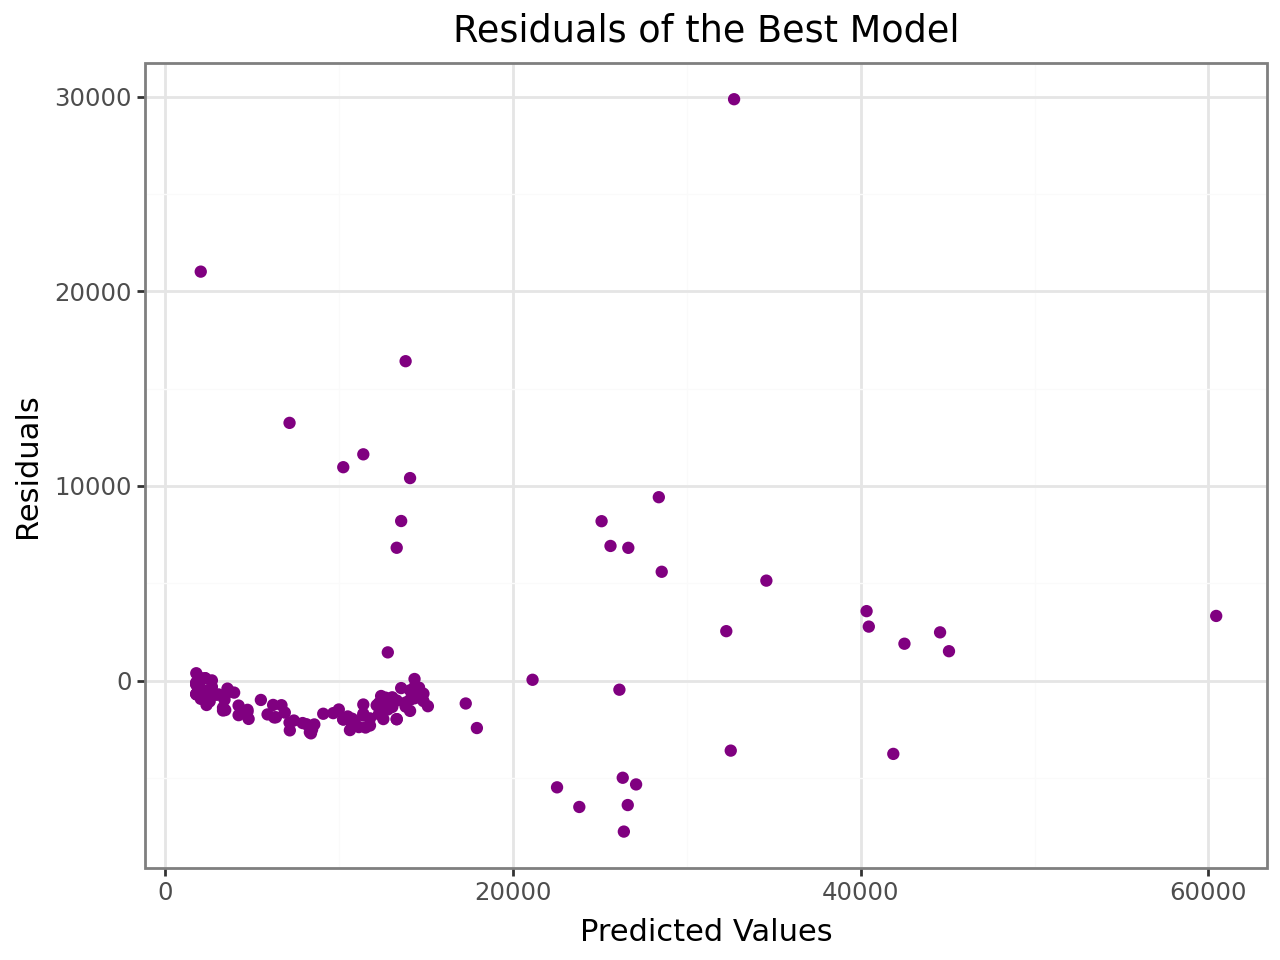

In [20]:
# Plot of residuals for best model

# Standardize 'age' and 'bmi' and dummify 'smoker'
ct_dummies = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"]),
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["smoker"]) # Reference group: no (non-smoker)
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

# Apply CT to training data to get column names
X_train_dummies = ct_dummies.fit_transform(X_train)
X_train_dummies

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__age", "dummify__smoker_yes"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__bmi", "dummify__smoker_yes"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__age", "standardize__bmi"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

lr_pipeline = Pipeline(
  [("preprocessing", ct_dummies),
   ("interactions", ct_inter),
   ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")

# Fit model to training set
lr_fit = lr_pipeline.fit(X_train, y_train)

# Predictions for train and test sets
y_train_pred = lr_fit.predict(X_train)
y_test_pred = lr_fit.predict(X_test)

# Calculate residuals
residuals = y_test - y_test_pred

# Create a DataFrame for plotting
residuals_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Residuals': residuals
})

# Plot residuals
(ggplot(residuals_df, aes(x='Predicted', y='Residuals')) +
    geom_point(color='purple') +
    labs(title="Residuals of the Best Model",
         x="Predicted Values",
         y="Residuals") +
    theme_bw()
)

This residual plot shows the difference between the actual and predicted values for the best model. There is a clustering of points close to zero residuals at lower predicted values, indicating accurate predictions in that range. However, there is a larger spread of residuals as predicted values increase, suggesting the model might be underestimating higher charges, leading to some prediction errors for these cases.

# Appendix and References  
- Linear Regression: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html  
- Polynomial Features: https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html  

Generative AI Statement:  
In this lab, ChatGPT 4o was very helpful in simplifying and automating tasks, especially in Section 5. It made setting up combinations of predictors and interactions easier, saving time and ensuring I tested a wide range of models. During debugging, ChatGPT 4o provided clear explanations for error messages, which helped me fix issues with data processing and feature mismatches between training and test sets. It also guided me in writing a function to find the best model by automatically calculating R-squared and MSE values, based on code from previous steps. Overall, ChatGPT 4o improved the efficiency and accuracy of the project, helping me organize my code and explore the best models more effectively.